# Forecasting Individual ATMs

In [2]:
from feature_generation import *
from forecasting import *

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df[atm_df<1] = 1
atm_df = clean_data(atm_df, drop_zeros=False)

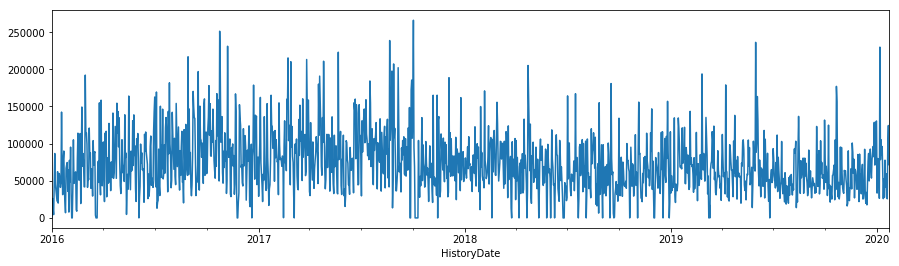

In [4]:
atm_df['CashIn'].plot(figsize=(15,4))

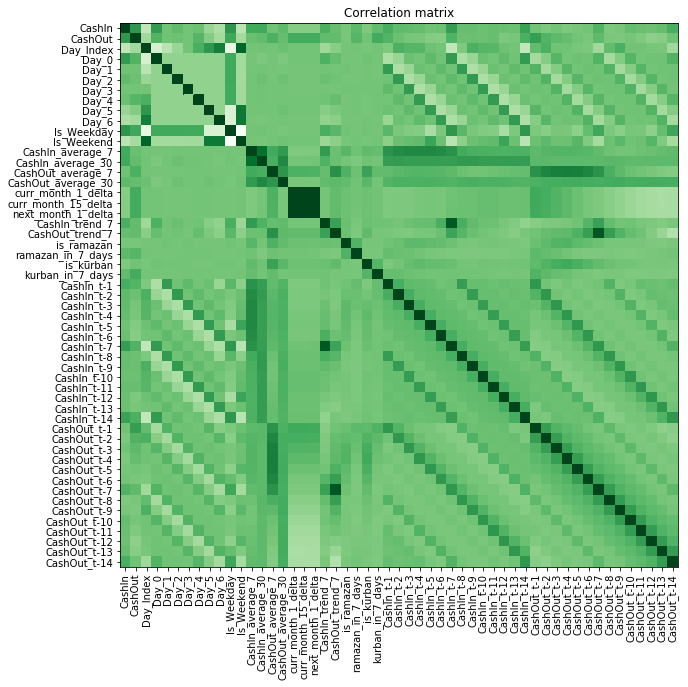

In [5]:
feature_set = get_feature_sets(atm_df, targets)
correlation(feature_set)

There is a visible difference in the correlation matrix when compared with the aggreagate correlation.

In [6]:
shifted_errors = get_shifted_errors(atm_df[targets], 21, average=[[7,14], [7,14,21]])

In [7]:
shifted_errors.sort_values(by='CashIn_Error')[:3]

,CashIn_Error,CashOut_Error
t-1,123524.619278,80580.099162
t-2,175464.303307,90114.173870
t-14,193065.348270,87123.449275


In [8]:
shifted_errors.sort_values(by='CashOut_Error')[:3]

,CashIn_Error,CashOut_Error
t-1,123524.619278,80580.099162
t-14,193065.348270,87123.449275
t-2,175464.303307,90114.173870


Because we there are low values in the dataset, MAPE is calculating astronomical errors

## Random Forest

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [10]:
target = 'CashIn'

X = feature_set[feature_set.columns[2:]]
y = feature_set[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

print("Predicting: %s" % target)

Predicting: CashIn


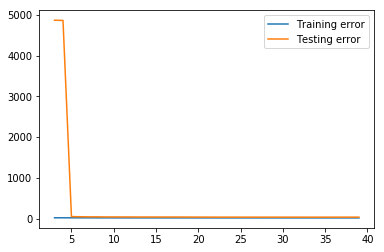

Best test error: 34.298 with 34 trees.


In [11]:
compare_model_parameter(RandomForestRegressor, X, y, 'n_estimators', list(range(3,40)), shuffle=False)

In [12]:
forest = RandomForestRegressor(n_estimators=34, random_state=5)
forest.fit(X_train, y_train)
print("Training error: %.4f" % mape_error(forest.predict(X_train), y_train))
print("Testing error:  %.4f" % mape_error(forest.predict(X_test), y_test))

Training error: 15.6729
Testing error:  34.2977


In [13]:
draw_model_error(forest, X, y, split_from=X_train.index[-1])

## LGBM

In [1]:
import optuna
from lightgbm import LGBMRegressor

C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\cahid\anaconda3\envs\arute\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [14]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, shuffle=False, test_size=0.2)
    param = {
        'metric': 'mape', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_error(test_y, preds)
    
    return mape

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-06 12:28:29,716] A new study created in memory with name: no-name-7209c66d-5054-4291-9136-5e9876a999e4
[I 2021-07-06 12:28:30,115] Trial 0 finished with value: 25561.78442761437 and parameters: {'reg_alpha': 0.03407876005935542, 'reg_lambda': 0.02185619231487927, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 292, 'min_child_samples': 105, 'min_data_per_groups': 30}. Best is trial 0 with value: 25561.78442761437.
[I 2021-07-06 12:28:30,188] Trial 1 finished with value: 25938.669229558524 and parameters: {'reg_alpha': 0.1547467612326979, 'reg_lambda': 0.00104042480539234, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 275, 'min_child_samples': 267, 'min_data_per_groups': 67}. Best is trial 0 with value: 25561.78442761437.
[I 2021-07-06 12:28:30,244] Trial 2 finished with value: 26404.061071088152 and parameters: {'reg_alpha': 0.018986501779371678, 'reg_lambda': 1.763475660626

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0315105393429038, 'reg_lambda': 0.030430677881506267, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 783, 'min_child_samples': 1, 'min_data_per_groups': 76}
Best value: 19602.93843881295


In [16]:
optuna.visualization.plot_optimization_history(study)

In [21]:
params=study.best_params   
#params = {'reg_alpha': 1.483192630608853, 'reg_lambda': 0.36626510385236044, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 348, 'min_child_samples': 6, 'min_data_per_groups': 91}
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mape'
params['cat_smooth'] = params.pop('min_data_per_groups')

In [22]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 10, shuffle=False)

predictions = np.zeros(len(X_test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_tra, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_tra, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = LGBMRegressor(**params)
   
    model.fit(X_tra, y_tra, eval_set = [(X_val, y_val)], eval_metric = 'mape', verbose = False, early_stopping_rounds = 222)
    
    predictions += model.predict(X_test) / folds.n_splits 

In [23]:
weekly_errors = get_error_with_freq(y_test, predictions, 'w')
draw_error_over_time(y_test, predictions, weekly_errors, X_train.index[-1])

In [24]:
"Test error of LGBM is %.3f." % mape_error(y_test, predictions)

'Test error of LGBM is 55834.604.'